# Building Autoencoders in Keras


### [Code & Text Source](https://blog.keras.io/building-autoencoders-in-keras.html)

## What are autoencoders?

![img](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are:
1. data-specific
> they will only be able to compress data similar to what they have been trained on
2. lossy
3. learned automatically from examples rather than engineered by a human.

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

---

To build an autoencoder, you need three things: 
- an encoding function
- a decoding function
- a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

## What are autoencoders good for?

- data denoising
- dimensionality reduction for data visualization

---

Other resources:
- [Keras blog: building autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Keras example: dAE](https://keras.io/examples/mnist_denoising_autoencoder/)
- [Keras blog: Data augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [blog about dAE in MNIST](https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/)
- [Github issues: jointly train autoencoder and classifier](https://github.com/keras-team/keras/issues/10037)
- [Loss function for AE](https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders)
- [Github issues: BN before or after ReLU](https://github.com/keras-team/keras/issues/5465)

In [1]:
from keras.models   import Model, load_model, model_from_json
from keras.layers   import Input, Dense, UpSampling2D, Reshape, Conv2DTranspose, LeakyReLU
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing     import OneHotEncoder

import h5py

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

%matplotlib inline

Using TensorFlow backend.


# CNN model for MNIST data 

## Load data and model

In [2]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

x_train = np.reshape( 
    (x_train_orig.astype('float32') / 255.), 
    (len(x_train_orig), x_train_orig.shape[1], x_train_orig.shape[2], 1) 
)

x_test  = np.reshape( 
    (x_test_orig.astype('float32')  / 255.), 
    (len(x_test_orig),  x_test_orig.shape[1],  x_test_orig.shape[2],  1) 
)

y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_train_orig.reshape(-1, 1))
y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_test_orig.reshape(-1, 1))

Accuracy: 0.9913


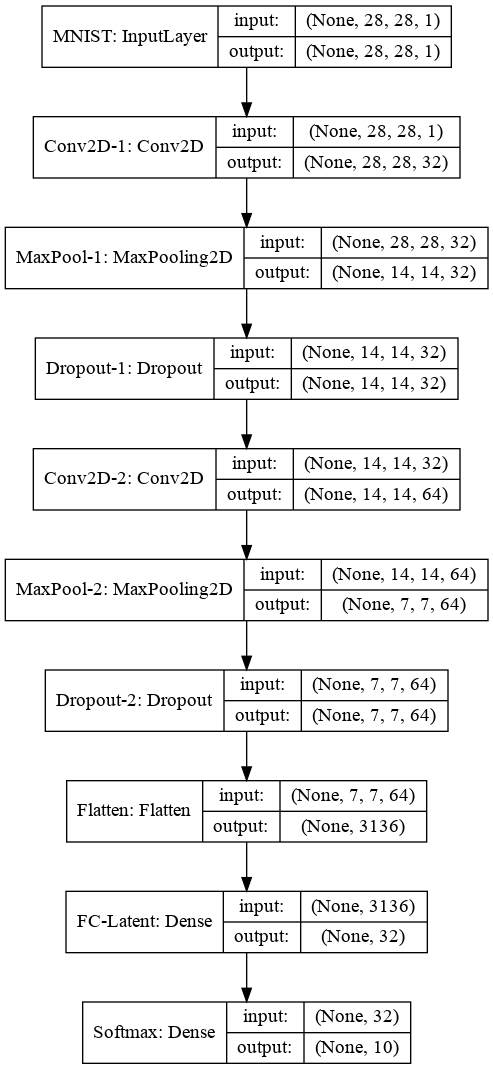

In [3]:
mnist_cnn_model = load_model('mnist_cnn_model.h5')
print('Accuracy:', mnist_cnn_model.evaluate(x_test, y_test, verbose=0)[1])
Image(filename='mnist_cnn_model.png',retina=True)

In [4]:
mnist_encoder = Model(inputs=mnist_cnn_model.input, outputs=mnist_cnn_model.get_layer(mnist_cnn_model.layers[-2].name).output, name='MNIST_encoder')
mnist_encoder.trainable = False
mnist_encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
mnist_encoder.trainable_weights
# mnist_encoder.summary()

[]

# Autoencoder for MNIST data 

In [5]:
mnist_z = Input(name='MNIST_Z', shape=(mnist_encoder.output.shape[1].value,))
x1 = Dense(7*7*64, activation='relu',      name='Latent-dFC')(mnist_z) 
x1 = Reshape((7, 7, 64),                   name='Reshape'   )(x1)
x1 = Conv2DTranspose( 64, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-1')(x1)
x1 = UpSampling2D(                         name='UpSample-1')(x1)
x1 = Conv2DTranspose( 32, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-2')(x1)
x1 = UpSampling2D(                         name='UpSample-2')(x1)
x1 = Conv2DTranspose( 1, kernel_size=(3, 3), 
    activation='sigmoid',  padding='same', name='deConv2D-3')(x1)
mnist_decoded = x1

In [6]:
mnist_decoder = Model(mnist_z, mnist_decoded, name='MNIST_decoder')

In [7]:
mnist_autoencoder = Model(
    inputs  = mnist_cnn_model.input, 
    outputs = mnist_decoder( mnist_encoder(mnist_cnn_model.input) ), 
    name='MNIST_autoencoder'
)

mnist_autoencoder.summary()
mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MNIST (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
MNIST_encoder (Model)        (None, 32)                119200    
_________________________________________________________________
MNIST_decoder (Model)        (None, 28, 28, 1)         159169    
Total params: 278,369
Trainable params: 159,169
Non-trainable params: 119,200
_________________________________________________________________


In [8]:
mnist_autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    verbose=2,
    validation_data=(x_test, x_test)
);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 27s - loss: 0.1780 - val_loss: 0.1549
Epoch 2/10
 - 26s - loss: 0.1454 - val_loss: 0.1330
Epoch 3/10
 - 26s - loss: 0.1384 - val_loss: 0.1287
Epoch 4/10
 - 26s - loss: 0.1346 - val_loss: 0.1268
Epoch 5/10
 - 26s - loss: 0.1320 - val_loss: 0.1243
Epoch 6/10
 - 26s - loss: 0.1305 - val_loss: 0.1225
Epoch 7/10
 - 26s - loss: 0.1290 - val_loss: 0.1246
Epoch 8/10
 - 26s - loss: 0.1277 - val_loss: 0.1245
Epoch 9/10
 - 26s - loss: 0.1266 - val_loss: 0.1193
Epoch 10/10
 - 26s - loss: 0.1260 - val_loss: 0.1198


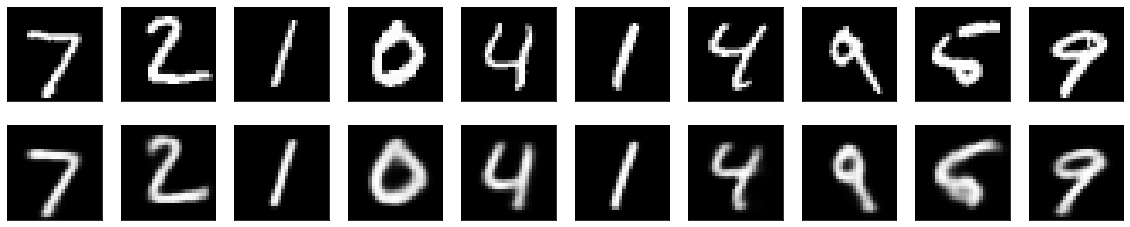

In [9]:
encoded_imgs = mnist_encoder.predict(x_test)
decoded_imgs = mnist_decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
print ( 
    'Accuracy Drop from ',
    np.round(mnist_cnn_model.evaluate(x_test,       y_test, verbose=0)[1],4),
   ' to ',
    np.round(mnist_cnn_model.evaluate(decoded_imgs, y_test, verbose=0)[1],4),
)

Accuracy Drop from  0.9913  to  0.9776


In [11]:
mnist_autoencoder.save('mnist_autoencoder.h5')

# Denoising Autoencoder

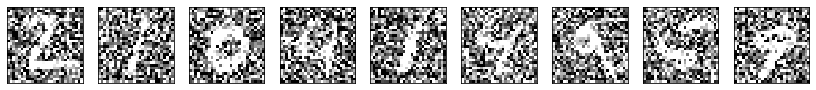

In [12]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
x_train_noisy = x_train + np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_test_noisy  = x_test  + np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy  = np.clip(x_test_noisy,  0, 1)

n = 10
plt.figure(figsize=(16, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
print ( 
    'Accuracy Drop from ',
    np.round(mnist_cnn_model.evaluate(x_test,       y_test, verbose=0)[1],4),
   ' to ',
    np.round(mnist_cnn_model.evaluate(x_test_noisy, y_test, verbose=0)[1],4),
)

Accuracy Drop from  0.9913  to  0.3379


In [14]:
## Load the autoencoder model without weights
mnist_autoencoder = model_from_json(load_model('mnist_autoencoder.h5',compile=False).to_json());
# mnist_autoencoder.layers[1].trainable = False
mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
mnist_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MNIST (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
MNIST_encoder (Model)        (None, 32)                119200    
_________________________________________________________________
MNIST_decoder (Model)        (None, 28, 28, 1)         159169    
Total params: 278,369
Trainable params: 278,369
Non-trainable params: 0
_________________________________________________________________


In [15]:
mnist_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    verbose=2,
    validation_data=(x_test_noisy, x_test)
);

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 - 38s - loss: 0.2728 - val_loss: 0.2647
Epoch 2/30
 - 37s - loss: 0.2541 - val_loss: 0.2192
Epoch 3/30
 - 37s - loss: 0.1827 - val_loss: 0.1522
Epoch 4/30
 - 37s - loss: 0.1507 - val_loss: 0.1357
Epoch 5/30
 - 37s - loss: 0.1386 - val_loss: 0.1334
Epoch 6/30
 - 37s - loss: 0.1319 - val_loss: 0.1297
Epoch 7/30
 - 37s - loss: 0.1276 - val_loss: 0.1219
Epoch 8/30
 - 37s - loss: 0.1244 - val_loss: 0.1166
Epoch 9/30
 - 37s - loss: 0.1218 - val_loss: 0.1197
Epoch 10/30
 - 37s - loss: 0.1199 - val_loss: 0.1120
Epoch 11/30
 - 37s - loss: 0.1183 - val_loss: 0.1111
Epoch 12/30
 - 37s - loss: 0.1167 - val_loss: 0.1105
Epoch 13/30
 - 37s - loss: 0.1155 - val_loss: 0.1092
Epoch 14/30
 - 37s - loss: 0.1149 - val_loss: 0.1089
Epoch 15/30
 - 37s - loss: 0.1140 - val_loss: 0.1082
Epoch 16/30
 - 37s - loss: 0.1131 - val_loss: 0.1073
Epoch 17/30
 - 37s - loss: 0.1125 - val_loss: 0.1078
Epoch 18/30
 - 37s - loss: 0.1120 - val_loss: 0.1060
Epoch

In [16]:
print ( 
    'Accuracy Drop from ',
    np.round(mnist_cnn_model.evaluate(x_test,                                  y_test, verbose=0)[1],4),
   ' to ',
    np.round(mnist_cnn_model.evaluate(mnist_autoencoder.predict(x_test_noisy), y_test, verbose=0)[1],4),
)

Accuracy Drop from  0.9913  to  0.9551


Original images: 1st rows
Corrupted Input: 2nd rows
Reconstruct Original: 3rd rows
Denoised Input: 4th rows


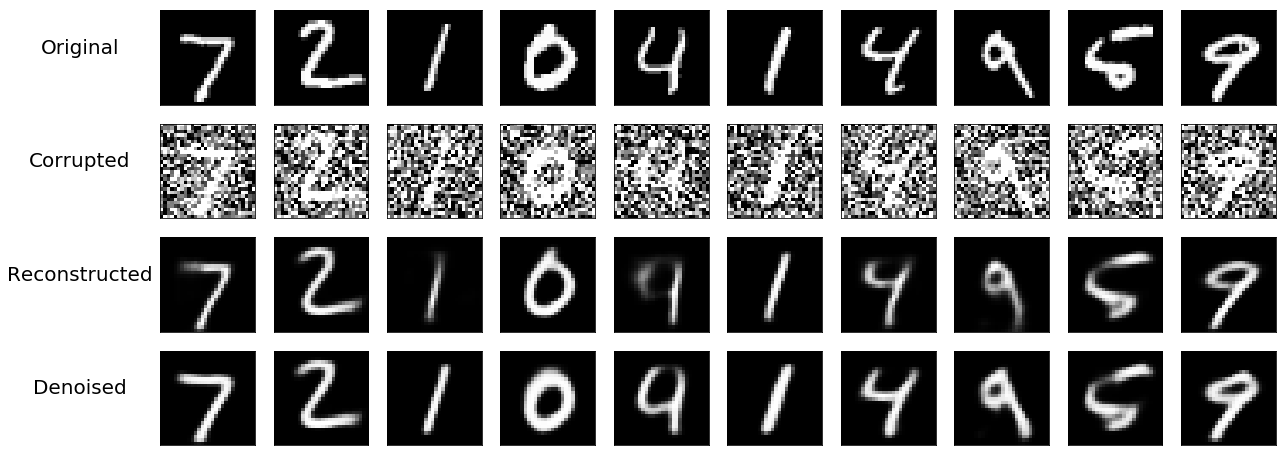

In [17]:
decoded_imgs       = mnist_autoencoder.predict(x_test[:100])
decoded_noisy_imgs = mnist_autoencoder.predict(x_test_noisy[:100])

n = 10  # how many digits we will display
plt.figure(figsize=(20, 8))
print('Original images: 1st rows')
print('Corrupted Input: 2nd rows')
print('Reconstruct Original: 3rd rows')
print('Denoised Input: 4th rows')

for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    if i == 0:
        ax.set_ylabel('Original',fontsize=20, rotation='horizontal',labelpad=80)

    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax = plt.subplot(4, n, i + 1 + n)
    if i == 0:
        ax.set_ylabel('Corrupted',fontsize=20, rotation='horizontal',labelpad=80)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    if i == 0:
        ax.set_ylabel('Reconstructed',fontsize=20, rotation='horizontal',labelpad=80)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.subplot(4, n, i + 1 + 3*n)
    if i == 0:
        ax.set_ylabel('Denoised',fontsize=20, rotation='horizontal',labelpad=80)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()

In [18]:
mnist_autoencoder.save('mnist_dAE.h5')

---
---
---

# CNN model for N-signs
- Datasets: https://www.floydhub.com/deeplearningai/datasets/signs
- Github: https://github.com/mesolmaz/HandSigns_CNN


***Warnings***

> Small dataset! Work well in CNN, but not work well in Autoencoder

## Load data

In [19]:
f1 = h5py.File("train_signs.h5", "r")
f2 = h5py.File("test_signs.h5",  "r")

# Loading the data (signs)
X_train_orig = np.array(f1['train_set_x'])
Y_train_orig = np.array(f1['train_set_y'])
X_test_orig  = np.array(f2['test_set_x'])
Y_test_orig  = np.array(f2['test_set_y'])

# print ("Training Data Feature Size = " + str(X_train_orig.shape))
# print ("Training Data Class Size = " + str(Y_train_orig.shape))
# print ("Test Data Feature Size = " + str(X_test_orig.shape))
# print ("Test Data Class Size = " + str(Y_test_orig.shape))

X_train = (X_train_orig / 255).astype('float32')
X_test  = (X_test_orig  / 255).astype('float32')

test_datagen  = ImageDataGenerator( rescale=1./255, )
train_datagen = ImageDataGenerator( rescale=1./255,
    width_shift_range  = 0.15,
    height_shift_range = 0.15,
    shear_range        = 0.3,
    zoom_range         = 0.1,
    rotation_range     = 30,
    horizontal_flip    = True,
    vertical_flip      = False,
    fill_mode          = 'nearest',
)

train_datagen.fit(X_train_orig)
test_datagen.fit(X_test_orig)


Y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_train_orig.reshape(-1, 1))
Y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_test_orig.reshape(-1, 1))

# (Y_train.argmax(axis=1) == Y_train_orig).all()

# print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
# print ("X_train shape: " + str(X_train.shape))
# print ("Y_train shape: " + str(Y_train.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

# # Example of a picture
# index = 1
# plt.imshow(X_train_orig[index])
# print ("y = " + str(Y_train_orig[index]))

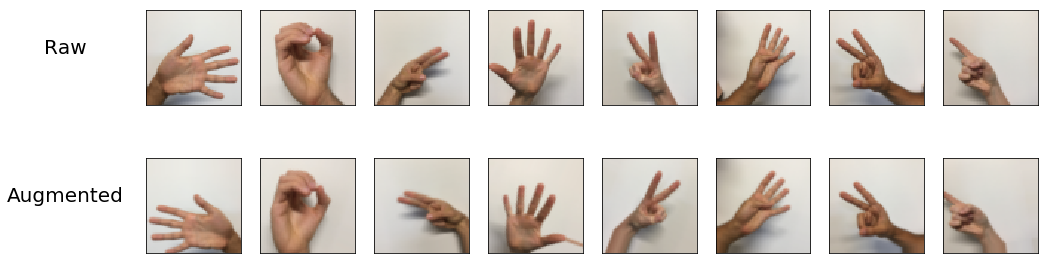

In [20]:
data_iter = train_datagen.flow(X_train_orig, batch_size=8, shuffle=False)

x_batch = data_iter.next()

plt.figure(figsize=(16,5))

for i in range(8):
    ax = plt.subplot(2,8,i+1)
    plt.imshow(X_train_orig[i].reshape(64,64,3), cmap='gray')
    if i == 0:
        ax.set_ylabel('Raw',fontsize=20, rotation='horizontal',labelpad=80)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax = plt.subplot(2,8,8+i+1)
    plt.imshow(x_batch[i].reshape(64,64,3), cmap='gray')
    if i == 0:
        ax.set_ylabel('Augmented',fontsize=20, rotation='horizontal',labelpad=80)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
        
plt.show()

Accuracy: 0.9666666666666667


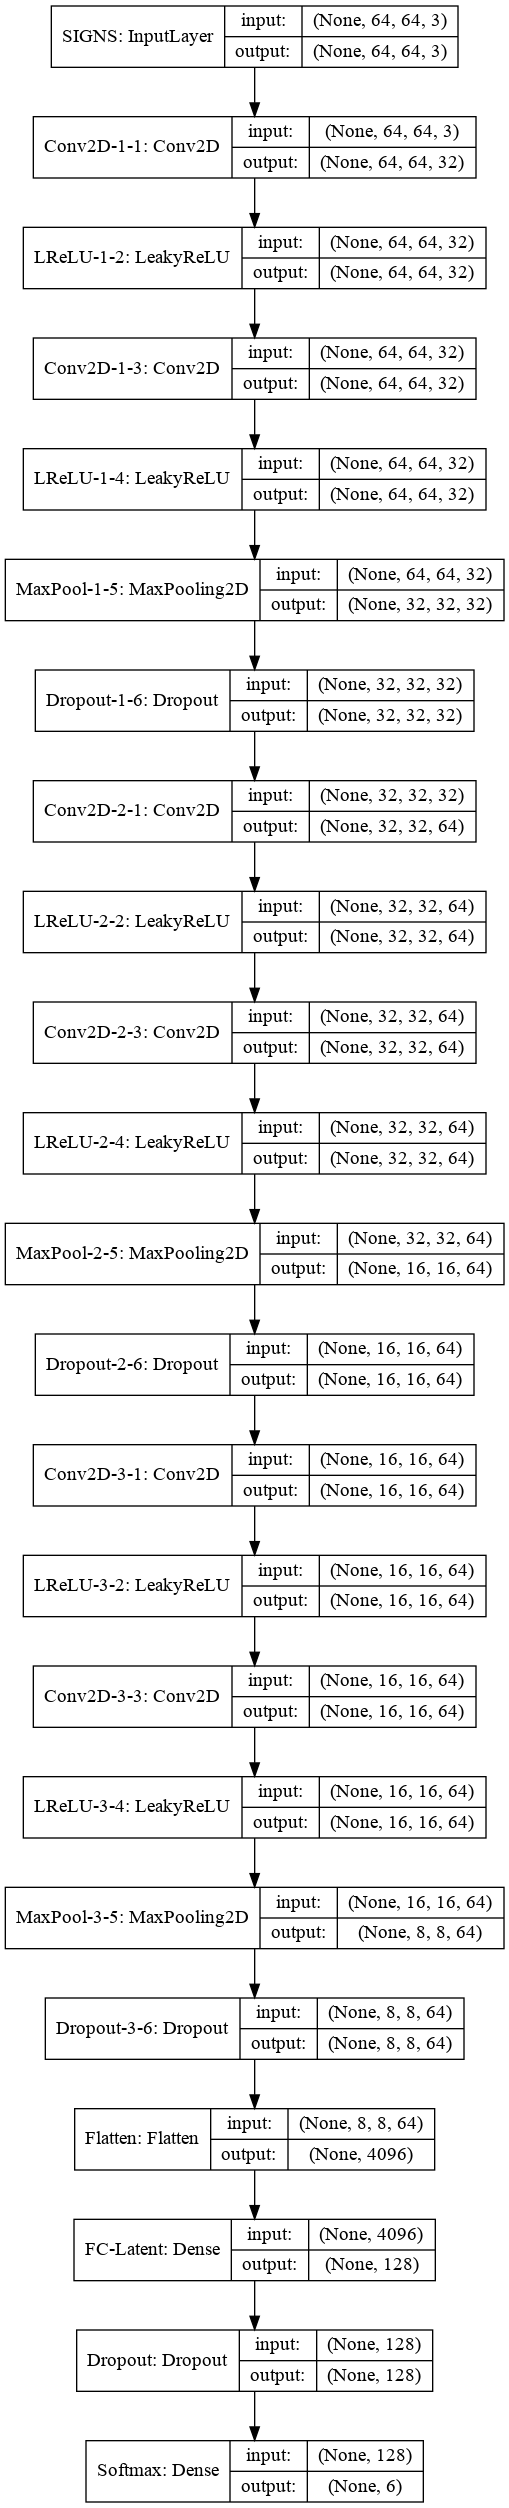

In [21]:
signs_cnn_model = load_model('signs_cnn_model.h5')
print('Accuracy:', signs_cnn_model.evaluate(X_test, Y_test, verbose=0)[1])
Image(filename='signs_cnn_model.png',retina=True)

In [22]:
signs_encoder = Model(inputs=signs_cnn_model.input, outputs=signs_cnn_model.get_layer(signs_cnn_model.layers[-2].name).output, name='SIGNS_encoder')
signs_encoder.trainable = False
signs_encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
signs_encoder.trainable_weights
# signs_encoder.summary()

[]

# Autoencoder for N-signs data 

- The CNN model



In [23]:
signs_z = Input(name='SIGNS_Z', shape=(signs_encoder.output.shape[1].value,))
x2 = Dense(4096, activation='relu',       name='Latent-dFC'  )(signs_z)
x2 = Reshape((8, 8, 64),                  name='Reshape'     )(x2)

x2 = Conv2DTranspose( 64, kernel_size=3, 
                          padding='same', name='deConv2D-1-1')(x2)
x2 = LeakyReLU(                           name='LReLU-1-2'   )(x2)
x2 = Conv2DTranspose( 64, kernel_size=3, 
                          padding='same', name='deConv2D-1-3')(x2)
x2 = LeakyReLU(                           name='LReLU-1-4'   )(x2)
x2 = UpSampling2D(                        name='UpSample-1-5')(x2)

x2 = Conv2DTranspose( 64, kernel_size=3, 
                          padding='same', name='deConv2D-2-1')(x2)
x2 = LeakyReLU(                           name='LReLU-2-2'   )(x2)
x2 = Conv2DTranspose( 64, kernel_size=3, 
                          padding='same', name='deConv2D-2-3')(x2)
x2 = LeakyReLU(                           name='LReLU-2-4'   )(x2)
x2 = UpSampling2D(                        name='UpSample-2-5')(x2)

x2 = Conv2DTranspose( 32, kernel_size=3, 
                          padding='same', name='deConv2D-3-1')(x2)
x2 = LeakyReLU(                           name='LReLU-3-2'   )(x2)
x2 = Conv2DTranspose( 32, kernel_size=3, 
                          padding='same', name='deConv2D-3-3')(x2)
x2 = LeakyReLU(                           name='LReLU-3-4'   )(x2)
x2 = UpSampling2D(                        name='UpSample-3-5')(x2)
x2 = Conv2DTranspose( 3, kernel_size=(3, 3),  
    activation='sigmoid', padding='same', name='deConv2D-4'  )(x2)
signs_decoded = x2

In [24]:
signs_decoder = Model(signs_z, signs_decoded, name='SIGNS_decoder')

In [25]:
signs_autoencoder = Model(
    inputs  = signs_encoder.input, 
    outputs = signs_decoder( signs_encoder(signs_encoder.input) ), 
    name='SIGNS_autoencoder'
)

signs_autoencoder.summary()
signs_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SIGNS (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
SIGNS_encoder (Model)        (None, 128)               663840    
_________________________________________________________________
SIGNS_decoder (Model)        (None, 64, 64, 3)         704675    
Total params: 1,368,515
Trainable params: 704,675
Non-trainable params: 663,840
_________________________________________________________________


In [26]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)
        
history = signs_autoencoder.fit_generator(
#     train_datagen.flow(X_train_orig, batch_size=32, shuffle=True),
    fixed_generator( train_datagen.flow(X_train_orig, batch_size=32, shuffle=True) ),
    validation_data=(X_test, X_test),
    epochs=150,
    verbose=2,
    steps_per_epoch=40,
)

# signs_autoencoder.fit(
#     X_train, X_train,
#     epochs=10,
#     batch_size=128,
#     shuffle=True,
#     verbose=2,
#     validation_data=(X_test, X_test)
# );

Epoch 1/150
 - 8s - loss: 0.6042 - val_loss: 0.5586
Epoch 2/150
 - 6s - loss: 0.5649 - val_loss: 0.5508
Epoch 3/150
 - 6s - loss: 0.5539 - val_loss: 0.5422
Epoch 4/150
 - 6s - loss: 0.5512 - val_loss: 0.5409
Epoch 5/150
 - 6s - loss: 0.5457 - val_loss: 0.5391
Epoch 6/150
 - 6s - loss: 0.5463 - val_loss: 0.5398
Epoch 7/150
 - 7s - loss: 0.5460 - val_loss: 0.5368
Epoch 8/150
 - 7s - loss: 0.5443 - val_loss: 0.5378
Epoch 9/150
 - 6s - loss: 0.5439 - val_loss: 0.5421
Epoch 10/150
 - 7s - loss: 0.5416 - val_loss: 0.5364
Epoch 11/150
 - 7s - loss: 0.5412 - val_loss: 0.5348
Epoch 12/150
 - 6s - loss: 0.5405 - val_loss: 0.5349
Epoch 13/150
 - 6s - loss: 0.5426 - val_loss: 0.5343
Epoch 14/150
 - 6s - loss: 0.5380 - val_loss: 0.5393
Epoch 15/150
 - 6s - loss: 0.5416 - val_loss: 0.5348
Epoch 16/150
 - 6s - loss: 0.5397 - val_loss: 0.5348
Epoch 17/150
 - 6s - loss: 0.5392 - val_loss: 0.5361
Epoch 18/150
 - 6s - loss: 0.5392 - val_loss: 0.5347
Epoch 19/150
 - 6s - loss: 0.5392 - val_loss: 0.5358
Ep

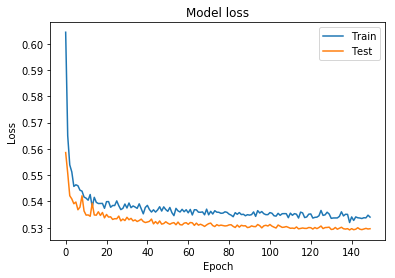

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

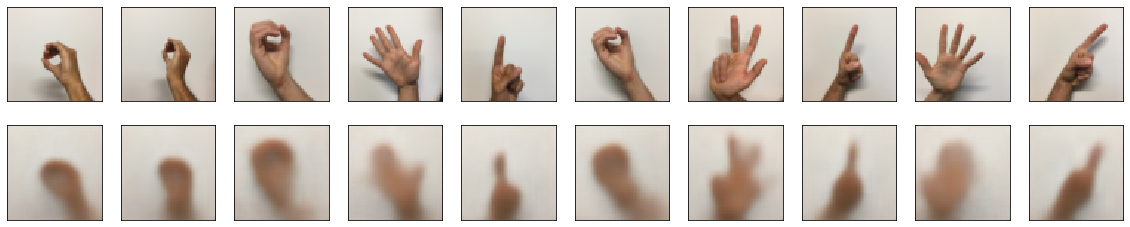

In [28]:
# encoded_imgs = signs_encoder.predict(X_test)
# decoded_imgs = signs_decoder.predict(encoded_imgs)
decoded_imgs = signs_autoencoder.predict(X_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
print ( 
    'Accuracy Drop from ',
    np.round(signs_cnn_model.evaluate(X_test,       Y_test, verbose=0)[1],3),
   ' to ',
    np.round(signs_cnn_model.evaluate(decoded_imgs, Y_test, verbose=0)[1],3),
)

Accuracy Drop from  0.967  to  0.783


In [30]:
signs_autoencoder.save('signs_autoencoder.h5')

---
---
---